# Задания на проведение A/A и A/B тестов

К вам пришла команда ML, которая сделала некоторые новые алгоритмы рекомендаций новостей в ленте.  Ожидается, что новые алгоритмы сделают пользователей счастливее (то есть удлинится LTV, повысятся денежные конверсии и т.д.), а продукт удобнее/приятнее в использовании. Мы должны проверить эту гипотезу.

Команда ML сказала нам «Рекомендации делают посты интереснее». **Сделано было два новых алгоритма рекомендаций:**  
`1. Показываем пользователю посты, наиболее похожие на те, которые он лайкал.`  
`2. Показываем пользователю посты, которые лайкали похожие на него пользователи.`

**Ключевая метрика - CTR из просмотров в лайки**

У нас параллельно идут два теста, оба – с **25 по 31 октября 2023**.

Первый тест:
* `exp_group = 1` - Все по-старому
* `exp_group = 2` - Рекомендации "похожих на лайкнутые постов"

Второй тест:
* `exp_group = 0` – Все по-старому
* `exp_group = 3` - Рекомендации "постов, которые лайкали похожие на вас люди"

## Задание №1

**Задание**:    
У нас есть данные А/А-теста с `18 октября по 24 октября 2023 года`. Необходимо сделать симуляцию, как будто мы провели 10000 А/А-тестов. На каждой итерации необходимо сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

**Шаги выполнения задания:**
1. Построить гистограмму распределения получившихся 10000 p-values.
2. Посчитать, какой процент p values оказался меньше либо равен 0.05
3. Написать вывод по проведенному А/А-тесту, корректно ли работает наша система сплитования.

In [1]:
# импортируем библиотеки
from scipy import *
import pandahouse as ph
import pandas as pd
import seaborn as sns
import numpy as np
from tqdm import tqdm

# Сделаем графики в seaborn покрупнее
sns.set(rc={'figure.figsize':(14, 10)})

In [2]:
#параметры соединения - нужны, чтобы подключиться к нужной схеме данных
connection = {'host': 'https://clickhouse.lab.karpov.courses',
              'database':'simulator',
              'user':'student',
              'password':'dpo_python_2020'}

In [3]:
#формулируем запрос

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20231113.feed_actions 
WHERE toDate(time) between '2023-10-18' and '2023-10-24'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

# сохраняем запрос в переменной df
df = ph.read_clickhouse(q, connection=connection)

#выведем 5 первых строк нашего датафрейма
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,38,248,0.153226
1,3,10326,24,132,0.181818
2,3,123580,25,122,0.204918
3,2,131473,19,98,0.193878
4,2,23985,12,44,0.272727


In [4]:
#проверяем равенство групп
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8362,8362,8362,8362
3,8425,8425,8425,8425


Здесь всё хорошо, наши группы равны.

### Визуализация распределений ctr и проведение т-теста.

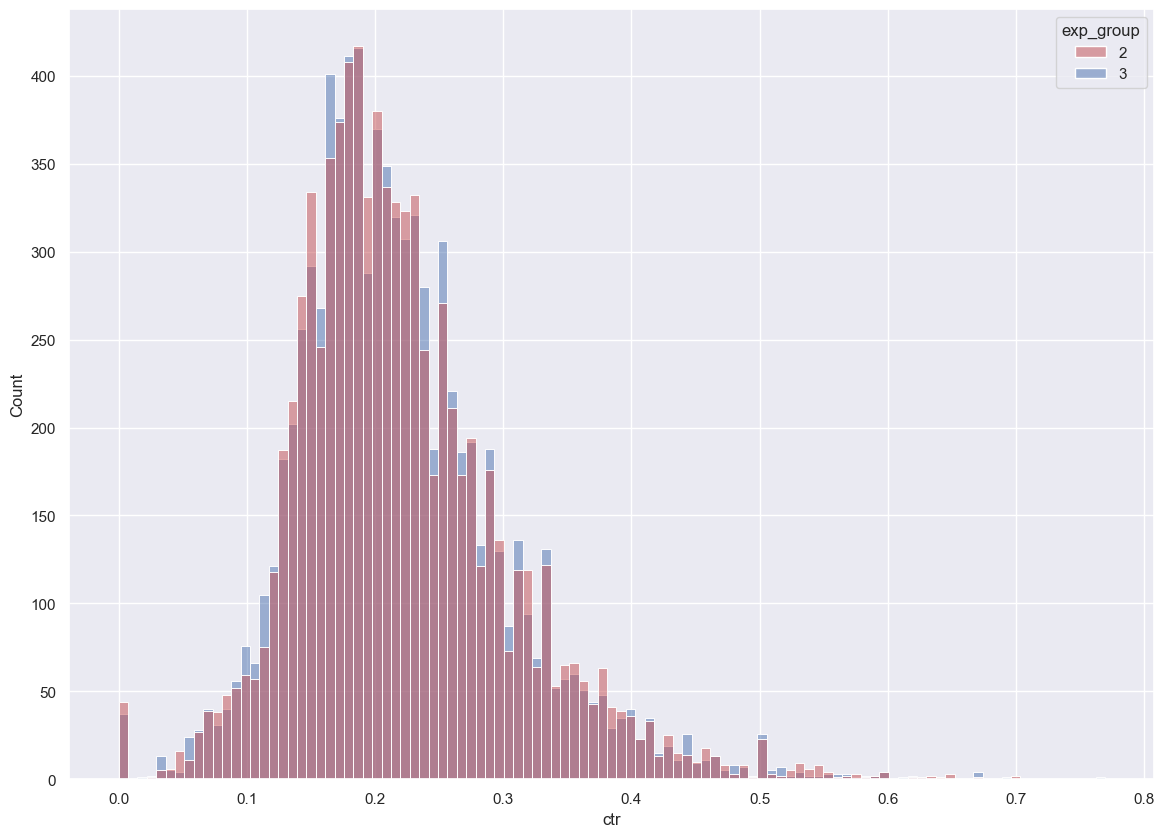

In [5]:
#построим гистограммы распределений наших групп
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

По гистограмме распределения ctr наши группы очень похожи.

In [6]:
# проверим средние значения выборок с помощью критерия T-стьюдента
T_stat, p_value = stats.ttest_ind(df.query('exp_group == 2').ctr, 
                df.query('exp_group == 3').ctr, 
                equal_var = False)

alpha = 0.05

print('T-Тест:')
print(f'p-value равен {round(p_value, 4)}')    

if p_value > alpha:
    print('Нет оснований считать, что распределения имеют различия')
else:
    print('Есть основания считать, что распределения имеют различия')

T-Тест:
p-value равен 0.5082
Нет оснований считать, что распределения имеют различия


**p-value > 0.05, поэтому у нас нет оснований предполагать, что средние значения двух выборок отличаются между собой**

### Моделирование 10000 A/A-тестов.

**Смоделируем 10000 А/А-тестов. На каждой итерации сформируем подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Проведем сравнение этих подвыборок t-testом.**

In [7]:
# создадим пустой список, сохранив туда сгенерированные pvalue
pvalue_list =[]

for _ in tqdm(range(10000)):
    sample_2 = df.query('exp_group == 2').sample(n=500,replace=False)
    sample_3 = df.query('exp_group == 3').sample(n=500,replace=False)
    statistic, pvalue = stats.ttest_ind(sample_2.ctr,
                                     sample_3.ctr,
                                     equal_var=False)
    pvalue_list.append(pvalue)

100%|████████████████████████████████████| 10000/10000 [00:26<00:00, 377.44it/s]


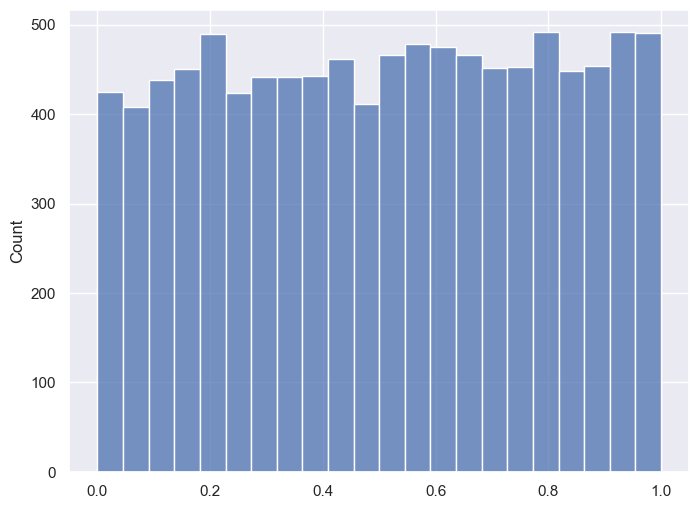

In [8]:
# построим гистограмму из полученных значений p-value
sns.set(rc={'figure.figsize':(8, 6)})
sns.histplot(data = pvalue_list);

In [9]:
#Посчитаем, какой процент p-values оказался меньше либо равен 0.05

print(f'В {len([i for i in pvalue_list if i <= 0.05]) / 100}% случаев p_value оказался меньше либо равен 0.05')

В 4.7% случаев p_value оказался меньше либо равен 0.05


### Вывод

**Сформулируем выводы после проведенного A/A теста:**
1. По изначальной гистограмме распределения групп 2 и 3 очень схожи и "на глаз" не различимы.
2. После моделирования 10000 A/A тестов только в 4.7% случаев p_value оказался меньше либо равен 0.05.

**Таким образом, наша система сплитования работает корректно.**

## Задание №2

# Анализ данных проведенного A/B-теста 

Необходимо проанализировать результаты эксперимента, который мы провели вместе с командой дата-сайентистов. Эксперимент проходил с `2023-10-25 по 2023-10-31` включительно. Для эксперимента были задействованы 1 и 2 группы. 

**В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля.** 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

**Наша задача — проанализировать данные А/B-теста.**

**Основные шаги:**

1. Проведём A/A-тест 1 и 2 группы с 18 по 24 октября 2023 года и проверим, что группы до теста равны.
2. Сравнить CTR в двух группах (с помощью t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
3. Сравнить данные между этими тестами. Определить, почему тесты сработали именно так? 
4. Описать потенциальную ситуацию, когда такое изменение могло произойти.
5. Написать рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей?

In [10]:
# Сделаем графики в seaborn покрупнее
sns.set(rc={'figure.figsize':(14, 10)})

### A/A тест

In [11]:
#формулируем запрос

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20231113.feed_actions 
WHERE toDate(time) between '2023-10-18' and '2023-10-24'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

# сохраняем запрос в переменной df
df = ph.read_clickhouse(q, connection=connection)

#выведем 5 первых строк нашего датафрейма
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,10,34,0.294118
1,1,18392,13,56,0.232143
2,2,131473,19,98,0.193878
3,2,23985,12,44,0.272727
4,2,24523,2,10,0.200000


In [12]:
#проверяем равенство групп
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,8491,8491,8491,8491
2,8362,8362,8362,8362


Группы наши почти равны.

**Построим распределение ctr 1 и 2 группы**

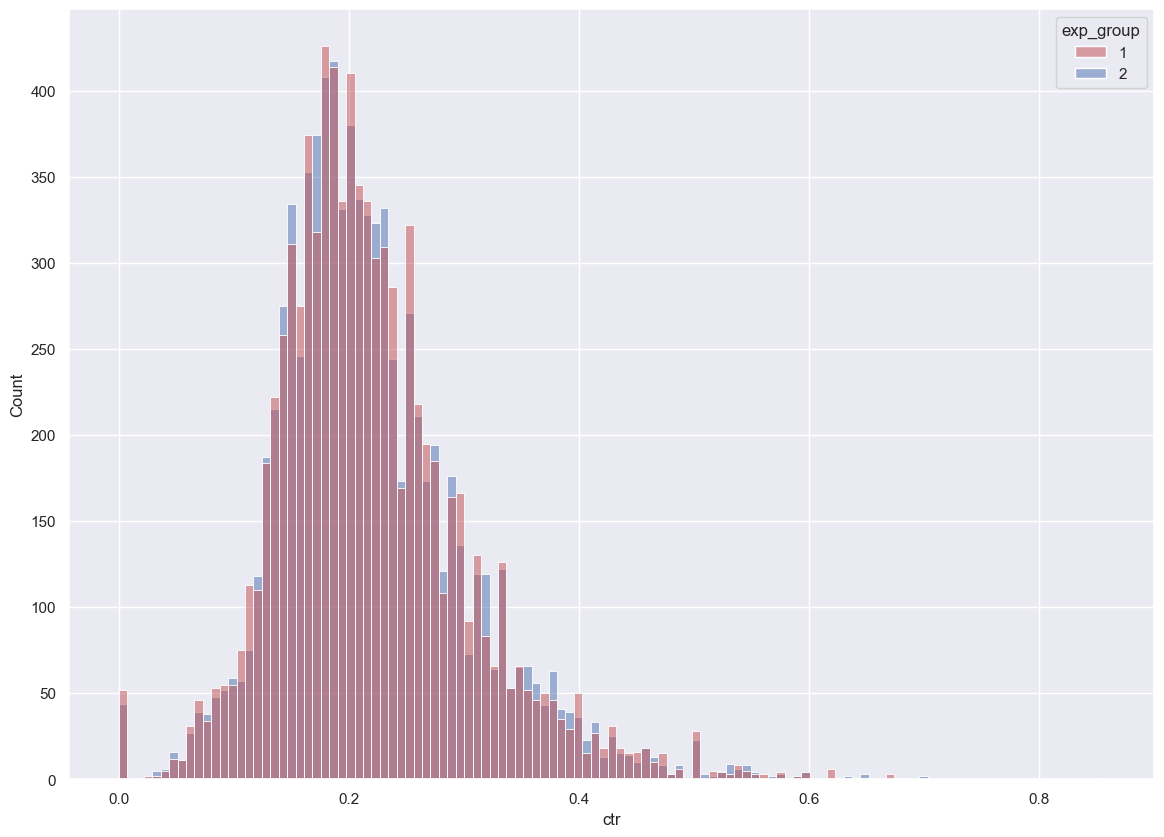

In [13]:
# строим гистограмму для двух групп
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

По гистограмме распределения ctr наши группы очень похожи.

In [14]:
# проверим средние значения выборок с помощью критерия T-стьюдента
T_stat, p_value = stats.ttest_ind(df.query('exp_group == 1').ctr, 
                df.query('exp_group == 2').ctr, 
                equal_var = False)

alpha = 0.05

print('T-Тест:')
print(f'p-value равен {round(p_value, 4)}')    

if p_value > alpha:
    print('Нет оснований считать, что распределения имеют различия')
else:
    print('Есть основания считать, что распределения имеют различия')

T-Тест:
p-value равен 0.569
Нет оснований считать, что распределения имеют различия


### Данные для A/B-теста. Распределение ctr.

In [15]:
#формулируем запрос
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20231113.feed_actions 
WHERE toDate(time) between '2023-10-25' and '2023-10-31'
    and exp_group in (1, 2)
GROUP BY exp_group, user_id
"""

# сохраняем запрос в переменной df
df = ph.read_clickhouse(q, connection=connection)

df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,18392,7,32,0.218750
4,1,26295,39,141,0.276596


In [16]:
#проверяем равенство групп
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10020,10020,10020,10020
2,9877,9877,9877,9877


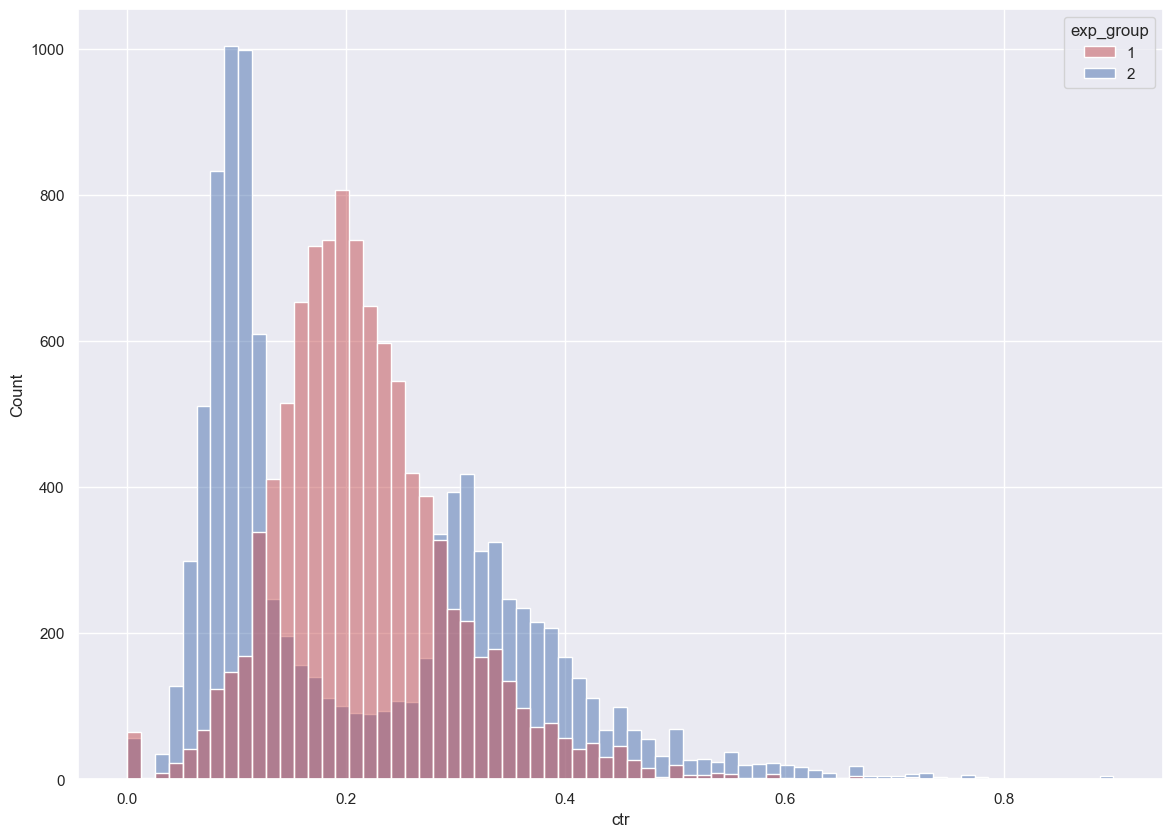

In [17]:
# строим гистограмму для двух групп
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [18]:
# выведем средние значения для двух групп
df.groupby('exp_group')['ctr'].mean()

exp_group
1    0.216774
2    0.216102
Name: ctr, dtype: float64

Интересно, что вторая группа имеет бимодальное распределение.  
Несмотря на то, что на гистограмме мы видим сильные различия между распределениями, есть предположение, что Т-тест покажет, что значимых отличий между группами нет. Это предположение связано с тем, что т-тест сравнивает средние двух выборок, а они, по нашей простой группировке, равны. Проверим это дальше.

### Результаты A/B тестов с помощью Т-теста и теста Манна-Уитни.

In [19]:
# проверим средние значения выборок с помощью критерия T-стьюдента
T_stat, p_value = stats.ttest_ind(df[df.exp_group == 1].ctr, 
                  df[df.exp_group == 2].ctr,
                  equal_var = False)

alpha = 0.05

print('T-Тест:')
print(f'p-value равен {round(p_value, 4)}')    

if p_value > alpha:
    print('Нет оснований считать, что распределения имеют различия')
else:
    print('Есть основания считать, что распределения имеют различия')

T-Тест:
p-value равен 0.6854
Нет оснований считать, что распределения имеют различия


In [20]:
# проверим значения выборок с помощью теста Манна-Уитни
stat, p_value = stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

print('Манна-Уитни:')
print(f'p-value равен {p_value}')    

if p_value > alpha:
    print('Нет оснований считать, что распределения имеют различия')
else:
    print('Есть основания считать, что распределения имеют различия')

Манна-Уитни:
p-value равен 4.632205841806026e-45
Есть основания считать, что распределения имеют различия


**Стандартные T-test и тест Манна-Уитни показывают противоположные результаты. Это логично, ведь T-критерий Стьюдента сравнивает средние двух выборок, а Манна-Уитни ранги.**

### Т-тест на сглаженном ctr.

In [21]:
# функция для сглаженного ctr
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [22]:
#рассчитаем глобальный ctr
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

In [23]:
group1 = df[df.exp_group == 1].copy()
group2 = df[df.exp_group == 2].copy()

#рассчитаем сглаженный ctr для двух групп
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

In [24]:
# проверим средние значения выборок с помощью критерия T-стьюдента
T_stat, p_value = stats.ttest_ind(group1.smothed_ctr, 
                group2.smothed_ctr, 
                equal_var = False)

alpha = 0.05

print('T-Тест на сглаженном ctr:')
print(f'p-value равен {round(p_value, 4)}')    

if p_value > alpha:
    print('Нет оснований считать, что распределения имеют различия')
else:
    print('Есть основания считать, что распределения имеют различия')

T-Тест на сглаженном ctr:
p-value равен 0.0517
Нет оснований считать, что распределения имеют различия


**Результаты p-value на сглаженном ctr схожи, что и для обычного ctr. Т-тест не показывает отличия между группами.**

### Пуассоновский бутстреп

In [25]:
#функция рассчета пуассоновского бутстрепа
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [26]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

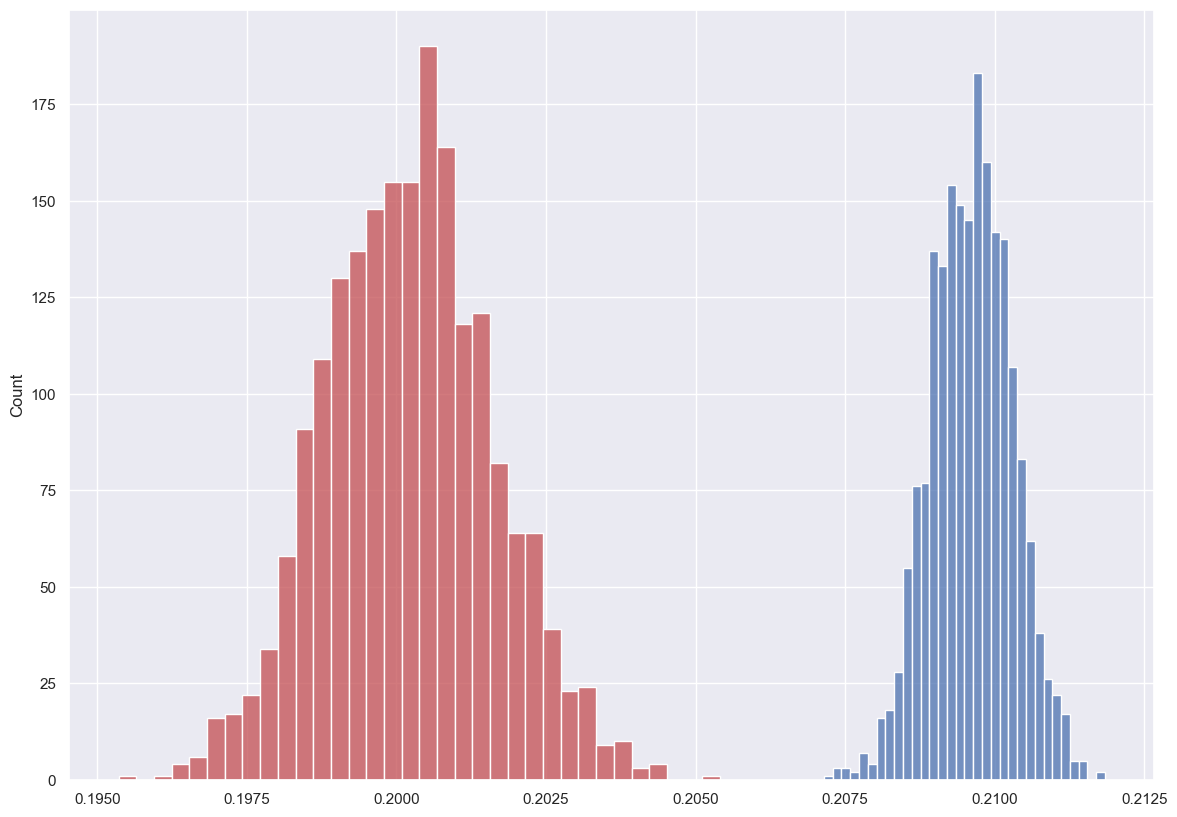

In [27]:
sns.histplot(ctr1)
sns.histplot(ctr2, color = 'r');

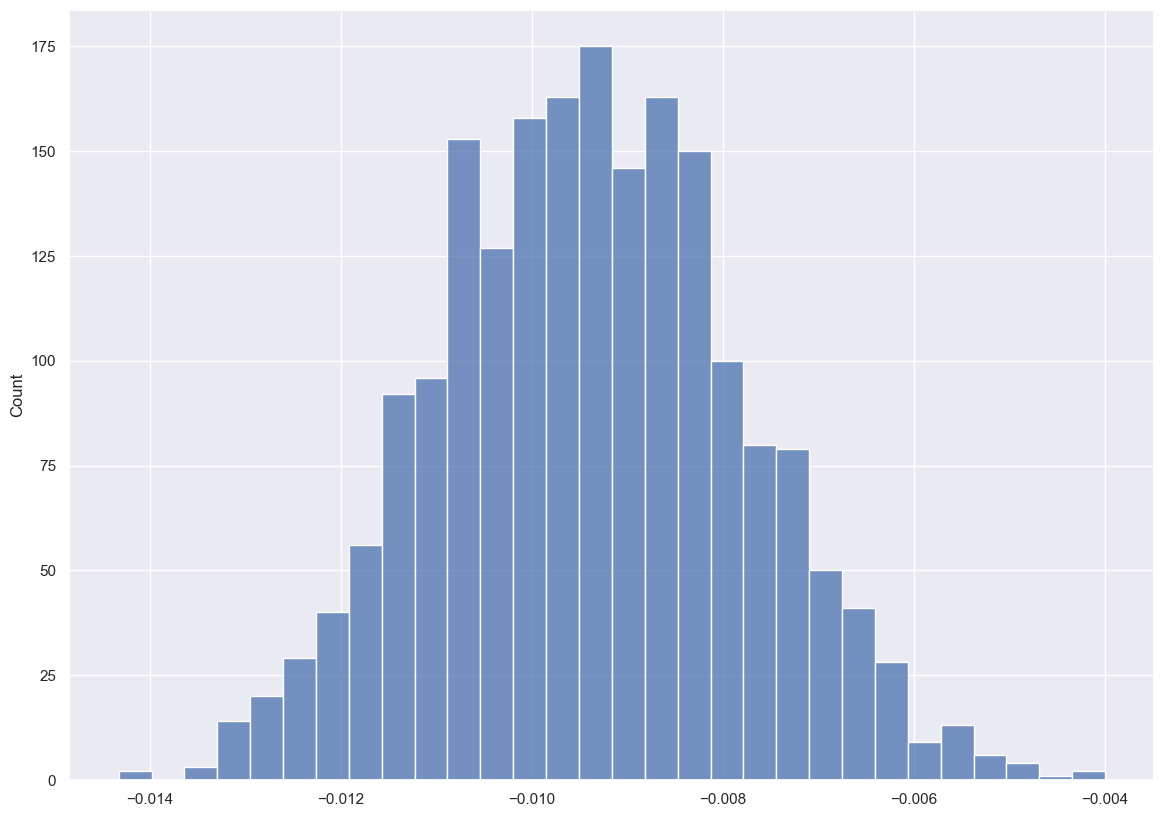

In [28]:
# Построим разницу между глобальными CTR
sns.histplot(ctr2 - ctr1);

**Поскольку разница между двумя ctr строго отрицательна, это значит, что ctr выше в контрольной группе, в которой мы не проводили изменений.**

### t-тест и тест Манна-Уитни поверх бакетного преобразования

In [29]:
q = """

SELECT exp_group, 
    bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id) % 50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20231113.feed_actions 
    WHERE toDate(time) between '2023-10-25' and '2023-10-31'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

bucket = ph.read_clickhouse(q, connection=connection)
bucket.head()

,exp_group,bucket,bucket_ctr
0,1,0,0.200592
1,2,0,0.196510
2,1,1,0.208799
3,2,1,0.210375
4,1,2,0.204632


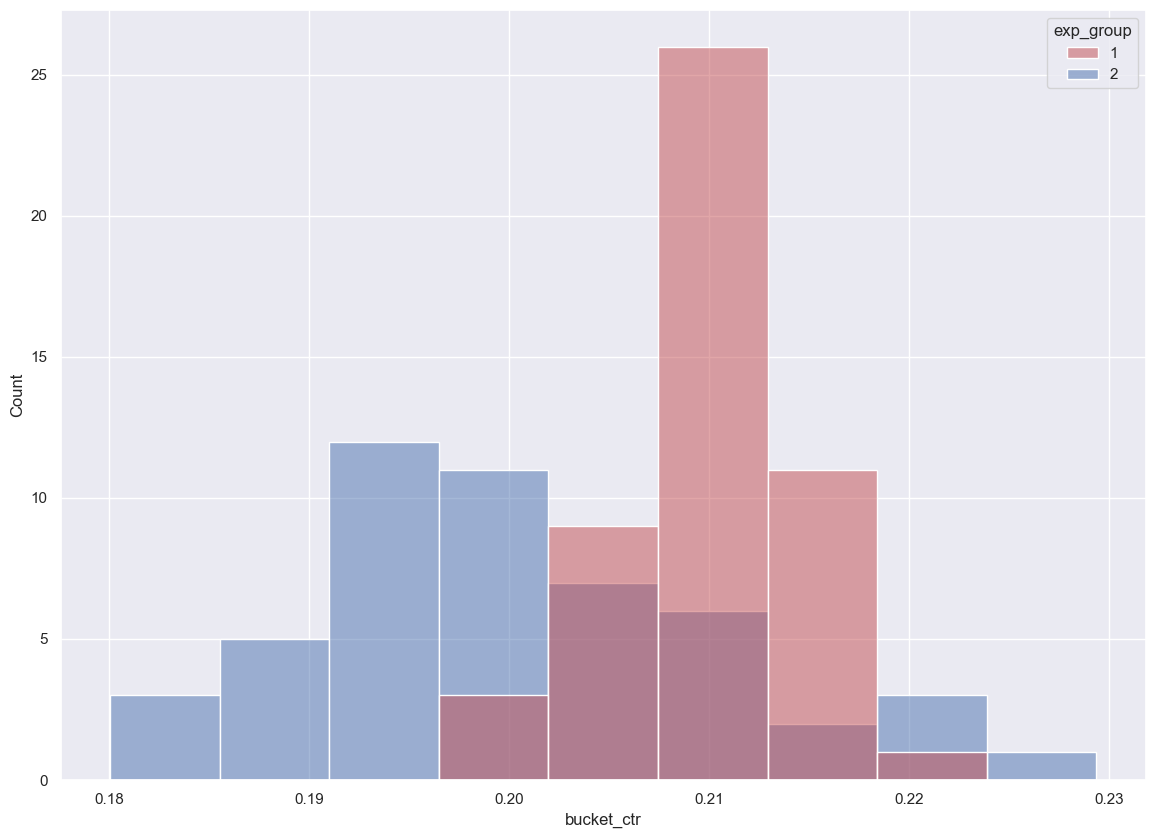

In [30]:
# строим гистограмму для двух групп
groups = sns.histplot(data = bucket, 
              x='bucket_ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

На гистограмме видим большие отличия между группами.

In [31]:
# проверим средние значения выборок с помощью критерия T-стьюдента
T_stat, p_value = stats.ttest_ind(bucket[bucket.exp_group == 1].bucket_ctr, 
                bucket[bucket.exp_group == 2].bucket_ctr, 
                equal_var = False)

alpha = 0.05

print('T-Тест поверх бакетного преобразования:')
print(f'p-value равен {p_value}')    

if p_value > alpha:
    print('Нет оснований считать, что распределения имеют различия')
else:
    print('Есть основания считать, что распределения имеют различия')

T-Тест поверх бакетного преобразования:
p-value равен 4.592644937473873e-07
Есть основания считать, что распределения имеют различия


In [32]:
# проверим значения выборок с помощью теста Манна_Уитни
stat, p_value = stats.mannwhitneyu(bucket[bucket.exp_group == 1].bucket_ctr, 
                bucket[bucket.exp_group == 2].bucket_ctr,
                   alternative = 'two-sided')

print('Манна-Уитни поверх бакетного преобразования:')
print(f'p-value равен {p_value}')    

if p_value > alpha:
    print('Нет оснований считать, что распределения имеют различия')
else:
    print('Есть основания считать, что распределения имеют различия')

Манна-Уитни поверх бакетного преобразования:
p-value равен 2.657642780401009e-07
Есть основания считать, что распределения имеют различия


**Оба теста показали отличия между группами.**

### Вывод

Наша основная гипотеза заключалась в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. Мы проанализировали результаты A/B теста с помощью разных методов:
- посмотрели на наши данные визуально, 
- т-тест и тест Манна-Уитни,
- т-тест на сглаженном ctr
- пуассоновский бутстреп
- т-тест и тест Манна_Уитни поверх бакетного преобразования.

**И мы можем выделить следующие результаты:**

1. Глядя на гистограммы распределений двух групп, мы видим сильные отличия. Тестовая группа имеет бимодальное распределение.
2. Стандартный т-тест и т-тест на сглаженном ctr отличий между группами не выявили, это связано с бимодальным распределением в тестовой группе.
3. Тест Манна-Уитни показал, что группы имеют отличия.
4. Пуассоновский бутстрэп показал отличия между группами, причем в контрольной группе ctr оказался выше.
5. Оба теста поверх бакетного преобразования показали отличия между группами.

Нам необходимо понять, с чем связано бимодальное распределение в тестовой группе. Можно предположить, что это связано с привыканием пользователей к новым рекомендациям или рекомендации корректировались в процессе теста.

**Раскатывать новый алгоритм на всех новых пользователей пока не стоит. Рекомендую проанализировать детальнее полученные результаты и повторить наш тест.**